# OCR Baseline using LPRNet (PyTorch)

This notebook implements the OCR pipeline using **LPRNet**, a lightweight Convolutional Neural Network designed for License Plate Recognition.

**Optimized for A100 GPU:**
- **Batch Size**: 1024
- **Mixed Precision**: Enabled (AMP)
- **Workers**: 8
- **Progress Tracking**: TQDM enabled
- **Metrics**: Sequence Acc, Char Acc, Edit Distance

**Steps:**
1. **Setup**: Import libraries and Modules.
2. **Data**: Load dataset using custom `LPRDataset`.
3. **Model**: Initialize `LPRNet`.
4. **Training**: Train the model using CTC Loss with AMP.
5. **Inference**: Evaluate on validation set.

In [ ]:
SEED = 2025
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

# Fungsi init worker
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
# Generator
g = torch.Generator()
g.manual_seed(SEED)

## 1. Setup

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler # Mixed Precision
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

# Add src to path if needed
sys.path.append('..')

from src.ocr.lprnet import build_lprnet
from src.ocr.reader import LPRDataset, collate_fn
from src.ocr.decoder import LPRLabelEncoder, CHARS
from src.evaluation.metrics import compute_ocr_metrics

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Check CUDA Capability
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.20 GB


## 2. Dataset Preparation

In [9]:
DATASET_DIR = "../datasets/preprocessed/plate_text_cropped"
IMAGES_DIR = os.path.join(DATASET_DIR, "dataset")
LABEL_FILE = os.path.join(DATASET_DIR, "label.csv")

# HPC Optimization
BATCH_SIZE = 16 # Increased for A100
NUM_WORKERS = 8   # Parallel data loading
PIN_MEMORY = True # Speed up host-to-device transfer

IMG_SIZE = (94, 24) # LPRNet standard input size

# Initialize Dataset
dataset = LPRDataset(img_dir=IMAGES_DIR, label_file=LABEL_FILE, img_size=IMG_SIZE)

# Split Dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          collate_fn=collate_fn, 
                          num_workers=NUM_WORKERS, 
                          pin_memory=PIN_MEMORY, 
                          worker_init_fn=seed_worker,
                          generator=g)

val_loader = DataLoader(val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False, 
                        collate_fn=collate_fn, 
                        num_workers=NUM_WORKERS, 
                        pin_memory=PIN_MEMORY,
                        worker_init_fn=seed_worker,
                        generator=g)

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

Train samples: 1490, Val samples: 373


## 3. Model Initialization

In [10]:
lpr_max_len = 18 # Maximum length of license plate
class_num = len(CHARS) + 1 # +1 for blank

model = build_lprnet(lpr_max_len=lpr_max_len, class_num=class_num, dropout_rate=0.5)
model.to(device)
# print(model) # Commented out to reduce log clutter

LPRNet(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (4): SmallBasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
        (3): ReLU()
        (4): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
        (5): ReLU()
        (6): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool3d(kernel_size=(1, 3, 3), stride=(2, 1, 2), padding=0, dilation=1, ceil_mode=False)
    (8): SmallBasicBlock(
      (block): Sequential(
        (0): Conv2d(64, 64, kern

## 4. Training Loop (with AMP & TQDM)

In [11]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler, epoch):
    model.train()
    total_loss = 0.0
    
    # Metrics accumulator
    total_seq_acc = 0.0
    total_char_acc = 0.0
    num_batches = 0
    
    encoder = LPRLabelEncoder(CHARS) # Helper untuk decode prediksi

    pbar = tqdm(loader, desc=f"Train Epoch {epoch+1}", leave=False)

    for images, labels, lengths in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        lengths = lengths.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            logits = model(images)                 # (B, C, T)
            log_probs = logits.permute(2, 0, 1)    # (T, B, C)
            log_probs = log_probs.log_softmax(2)

            input_lengths = torch.full(
                size=(images.size(0),),
                fill_value=logits.size(2),
                dtype=torch.long,
                device=device
            )

            loss = criterion(log_probs, labels, input_lengths, lengths)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        

        # --- Calculate Train Metrics on the Fly ---
        # Decode greedy untuk hitung akurasi kasar saat training
        with torch.no_grad():
            preds_decoded = encoder.decode_greedy(logits)
            
            # Reconstruct targets text
            labels_cpu = labels.cpu().numpy()
            lengths_cpu = lengths.cpu().numpy()
            targets_decoded = []
            idx = 0
            for le in lengths_cpu:
                targets_decoded.append("".join([CHARS[c] for c in labels_cpu[idx:idx+le]]))
                idx += le
                
            # Compute Batch Metrics
            batch_metrics = compute_ocr_metrics(preds_decoded, targets_decoded)
            total_seq_acc += batch_metrics["seq_acc"]
            total_char_acc += batch_metrics["char_acc"]
            num_batches += 1

        total_loss += loss.item()
        pbar.set_postfix({
            "loss": f"{loss.item():.4f}", 
            "acc": f"{batch_metrics['seq_acc']:.2%}"
        })

    avg_loss = total_loss / num_batches
    avg_seq_acc = total_seq_acc / num_batches
    avg_char_acc = total_char_acc / num_batches
    
    return avg_loss, avg_seq_acc, avg_char_acc

def evaluate(model, loader, device):
    model.eval()
    encoder = LPRLabelEncoder(CHARS)

    all_preds = []
    all_targets = []

    pbar = tqdm(loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for images, labels, lengths in pbar:
            images = images.to(device, non_blocking=True)

            with autocast():
                logits = model(images)

            preds = encoder.decode_greedy(logits)

            labels = labels.cpu().numpy()
            lengths = lengths.cpu().numpy()

            idx = 0
            for i, length in enumerate(lengths):
                true_indices = labels[idx : idx + length]
                true_text = "".join([CHARS[j] for j in true_indices])
                idx += length

                all_preds.append(preds[i])
                all_targets.append(true_text)

    metrics = compute_ocr_metrics(all_preds, all_targets)
    return metrics

In [13]:
num_epochs = 100
patience = 15
best_seq_acc = 0.0
epochs_no_improve = 0

save_dir = "../artifacts/lprnet"
os.makedirs(save_dir, exist_ok=True)

criterion = nn.CTCLoss(blank=len(CHARS), reduction='mean')

optimizer = optim.Adam(
    model.parameters(),
    lr=0.001
)

scheduler = optim.lr_scheduler.StepLR(
    optimizer,
    step_size=20,
    gamma=0.5
)

scaler = GradScaler()


# --- History Storage ---
history = {
    "train_loss": [],
    "train_seq_acc": [],
    "val_seq_acc": [],
    "train_char_acc": [],
    "val_char_acc": [],
    "val_edit_dist": []
}

print("Starting Training...\n")

for epoch in range(num_epochs):
    # Pass scheduler ke dalam train_one_epoch agar di-step per batch
    train_loss, train_seq_acc, train_char_acc = train_one_epoch(
        model,
        train_loader,
        optimizer,
        criterion,
        device,
        scaler,
        epoch
    )
    
    scheduler.step()
    
    # ... (Evaluate) ...
    metrics = evaluate(model, val_loader, device)
    val_seq_acc = metrics["seq_acc"]
    val_char_acc = metrics["char_acc"]
    val_edit_dist = metrics["avg_edit_dist"]
    
    # --- SIMPAN KE HISTORY ---
    history["train_loss"].append(train_loss)
    history["train_seq_acc"].append(train_seq_acc)
    history["val_seq_acc"].append(val_seq_acc)
    history["train_char_acc"].append(train_char_acc)
    history["val_char_acc"].append(val_char_acc)
    history["val_edit_dist"].append(val_edit_dist)

    print(
        f"Epoch [{epoch+1}/{num_epochs}] "
        f"Loss: {train_loss:.4f} | "
        f"Train Acc: {train_seq_acc:.4f} | "  
        f"Val Acc: {val_seq_acc:.4f} | "      
        f"Val Char: {val_char_acc:.4f} | "
        f"Edit Dist: {val_edit_dist:.4f}"
    )

    # Save Best Model berdasarkan Val Seq Accuracy
    if val_seq_acc > best_seq_acc:
        best_seq_acc = val_seq_acc
        epochs_no_improve = 0
        torch.save(
            model.state_dict(),
            os.path.join(save_dir, "lprnet_best.pth")
        )
        print(f"Best model saved (Seq Acc: {best_seq_acc:.4f})")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

# Save Last
torch.save(
    model.state_dict(),
    os.path.join(save_dir, "lprnet_last.pth")
)
print("\nTraining finished")
print(f"Best Seq Accuracy: {best_seq_acc:.4f}")
print(f"Models saved in: {save_dir}")

Starting Training...



Epoch [1/100] Loss: 2.8781 | Train Acc: 0.0000 | Val Acc: 0.0000 | Val Char: 0.2789 | Edit Dist: 5.3029


Epoch [2/100] Loss: 2.1877 | Train Acc: 0.0033 | Val Acc: 0.0027 | Val Char: 0.3839 | Edit Dist: 4.5308
Best model saved (Seq Acc: 0.0027)


Epoch [3/100] Loss: 1.6955 | Train Acc: 0.0273 | Val Acc: 0.0349 | Val Char: 0.5403 | Edit Dist: 3.3807
Best model saved (Seq Acc: 0.0349)


Epoch [4/100] Loss: 1.3903 | Train Acc: 0.0705 | Val Acc: 0.1153 | Val Char: 0.6354 | Edit Dist: 2.6810
Best model saved (Seq Acc: 0.1153)


Epoch [5/100] Loss: 1.2396 | Train Acc: 0.1230 | Val Acc: 0.1046 | Val Char: 0.5884 | Edit Dist: 3.0268


Epoch [6/100] Loss: 1.1096 | Train Acc: 0.1642 | Val Acc: 0.0804 | Val Char: 0.6216 | Edit Dist: 2.7828


Epoch [7/100] Loss: 0.9909 | Train Acc: 0.2035 | Val Acc: 0.1796 | Val Char: 0.6591 | Edit Dist: 2.5067
Best model saved (Seq Acc: 0.1796)


Epoch [8/100] Loss: 0.9253 | Train Acc: 0.2374 | Val Acc: 0.1984 | Val Char: 0.6974 | Edit Dist: 2.2252
Best model saved (Seq Acc: 0.1984)


Epoch [9/100] Loss: 0.8413 | Train Acc: 0.2766 | Val Acc: 0.2225 | Val Char: 0.7054 | Edit Dist: 2.1662
Best model saved (Seq Acc: 0.2225)


Epoch [10/100] Loss: 0.7985 | Train Acc: 0.3059 | Val Acc: 0.2172 | Val Char: 0.7080 | Edit Dist: 2.1475


Epoch [11/100] Loss: 0.7639 | Train Acc: 0.3118 | Val Acc: 0.2681 | Val Char: 0.7320 | Edit Dist: 1.9705
Best model saved (Seq Acc: 0.2681)


Epoch [12/100] Loss: 0.7118 | Train Acc: 0.3311 | Val Acc: 0.2761 | Val Char: 0.7156 | Edit Dist: 2.0912
Best model saved (Seq Acc: 0.2761)


Epoch [13/100] Loss: 0.6694 | Train Acc: 0.3657 | Val Acc: 0.3164 | Val Char: 0.7598 | Edit Dist: 1.7668
Best model saved (Seq Acc: 0.3164)


Epoch [14/100] Loss: 0.6336 | Train Acc: 0.3870 | Val Acc: 0.2386 | Val Char: 0.7160 | Edit Dist: 2.0885


Epoch [15/100] Loss: 0.5919 | Train Acc: 0.4176 | Val Acc: 0.3485 | Val Char: 0.7769 | Edit Dist: 1.6408
Best model saved (Seq Acc: 0.3485)


Epoch [16/100] Loss: 0.5985 | Train Acc: 0.4136 | Val Acc: 0.2815 | Val Char: 0.7514 | Edit Dist: 1.8284


Epoch [17/100] Loss: 0.5673 | Train Acc: 0.4382 | Val Acc: 0.3137 | Val Char: 0.7718 | Edit Dist: 1.6783


Epoch [18/100] Loss: 0.5244 | Train Acc: 0.4461 | Val Acc: 0.3137 | Val Char: 0.7707 | Edit Dist: 1.6863


Epoch [19/100] Loss: 0.5007 | Train Acc: 0.4781 | Val Acc: 0.3512 | Val Char: 0.7725 | Edit Dist: 1.6729
Best model saved (Seq Acc: 0.3512)


Epoch [20/100] Loss: 0.4646 | Train Acc: 0.4894 | Val Acc: 0.3592 | Val Char: 0.7842 | Edit Dist: 1.5871
Best model saved (Seq Acc: 0.3592)


Epoch [21/100] Loss: 0.3832 | Train Acc: 0.5691 | Val Acc: 0.4290 | Val Char: 0.8101 | Edit Dist: 1.3968
Best model saved (Seq Acc: 0.4290)


Epoch [22/100] Loss: 0.3325 | Train Acc: 0.6117 | Val Acc: 0.4343 | Val Char: 0.8119 | Edit Dist: 1.3834
Best model saved (Seq Acc: 0.4343)


Epoch [23/100] Loss: 0.3142 | Train Acc: 0.6257 | Val Acc: 0.4397 | Val Char: 0.8166 | Edit Dist: 1.3485
Best model saved (Seq Acc: 0.4397)


Epoch [24/100] Loss: 0.2911 | Train Acc: 0.6410 | Val Acc: 0.4531 | Val Char: 0.8217 | Edit Dist: 1.3110
Best model saved (Seq Acc: 0.4531)


Epoch [25/100] Loss: 0.2915 | Train Acc: 0.6350 | Val Acc: 0.4424 | Val Char: 0.8265 | Edit Dist: 1.2761


Epoch [26/100] Loss: 0.2679 | Train Acc: 0.6742 | Val Acc: 0.4209 | Val Char: 0.8148 | Edit Dist: 1.3619


Epoch [27/100] Loss: 0.2736 | Train Acc: 0.6562 | Val Acc: 0.3995 | Val Char: 0.8024 | Edit Dist: 1.4531


Epoch [28/100] Loss: 0.2613 | Train Acc: 0.6762 | Val Acc: 0.4343 | Val Char: 0.8163 | Edit Dist: 1.3512


Epoch [29/100] Loss: 0.2563 | Train Acc: 0.6676 | Val Acc: 0.4424 | Val Char: 0.8210 | Edit Dist: 1.3164


Epoch [30/100] Loss: 0.2450 | Train Acc: 0.6755 | Val Acc: 0.4343 | Val Char: 0.8177 | Edit Dist: 1.3405


Epoch [31/100] Loss: 0.2339 | Train Acc: 0.6915 | Val Acc: 0.4102 | Val Char: 0.8144 | Edit Dist: 1.3646


Epoch [32/100] Loss: 0.2758 | Train Acc: 0.6363 | Val Acc: 0.4450 | Val Char: 0.8104 | Edit Dist: 1.3941


Epoch [33/100] Loss: 0.2330 | Train Acc: 0.6981 | Val Acc: 0.4477 | Val Char: 0.8246 | Edit Dist: 1.2895


Epoch [34/100] Loss: 0.2352 | Train Acc: 0.6689 | Val Acc: 0.4182 | Val Char: 0.8108 | Edit Dist: 1.3914


Epoch [35/100] Loss: 0.2080 | Train Acc: 0.7161 | Val Acc: 0.4102 | Val Char: 0.8181 | Edit Dist: 1.3378


Epoch [36/100] Loss: 0.2499 | Train Acc: 0.6742 | Val Acc: 0.4477 | Val Char: 0.8272 | Edit Dist: 1.2708


Epoch [37/100] Loss: 0.2355 | Train Acc: 0.6828 | Val Acc: 0.4343 | Val Char: 0.8148 | Edit Dist: 1.3619


Epoch [38/100] Loss: 0.1865 | Train Acc: 0.7254 | Val Acc: 0.4477 | Val Char: 0.8195 | Edit Dist: 1.3271


Epoch [39/100] Loss: 0.1978 | Train Acc: 0.7134 | Val Acc: 0.4209 | Val Char: 0.8174 | Edit Dist: 1.3432

Early stopping triggered after 39 epochs

Training finished
Best Seq Accuracy: 0.4531
Models saved in: ../artifacts/lprnet


## 5. Inference Visualization

Loading best model from: ../artifacts/lprnet/lprnet_best.pth


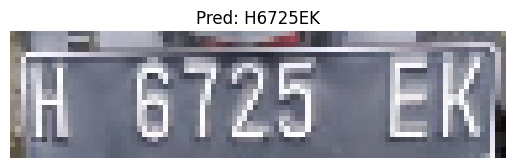

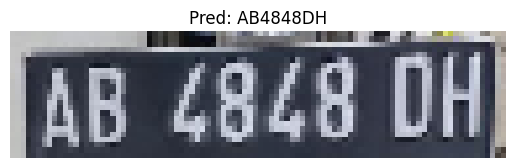

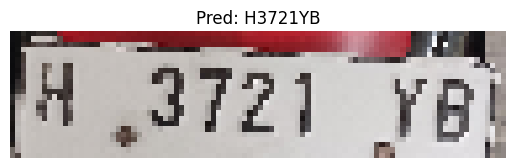

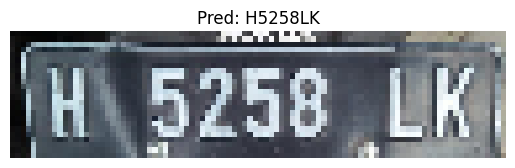

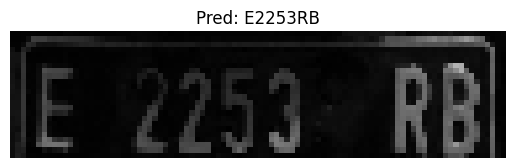

In [14]:
def show_results(model, dataset, num=5):
    model.eval()
    encoder = LPRLabelEncoder(CHARS)
    
    indices = np.random.randint(0, len(dataset), num)
    
    for idx in indices:
        img_tensor, _, _ = dataset[idx]
        input_img = img_tensor.unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = model(input_img)
            pred_text = encoder.decode_greedy(logits)[0]
            
        # De-normalize for plotting
        display_img = img_tensor.numpy().transpose(1, 2, 0)
        display_img = (display_img / 0.0078125) + 127.5
        display_img = display_img.astype(np.uint8)
        
        plt.figure()
        plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Pred: {pred_text}")
        plt.axis('off')
        plt.show()

# --- Load Best Model untuk Visualisasi ---
best_model_path = os.path.join(save_dir, "lprnet_best.pth")
if os.path.exists(best_model_path):
    print(f"Loading best model from: {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))
else:
    print("Best model not found, using last model.")
# Baru panggil fungsi show_results
show_results(model, val_dataset)

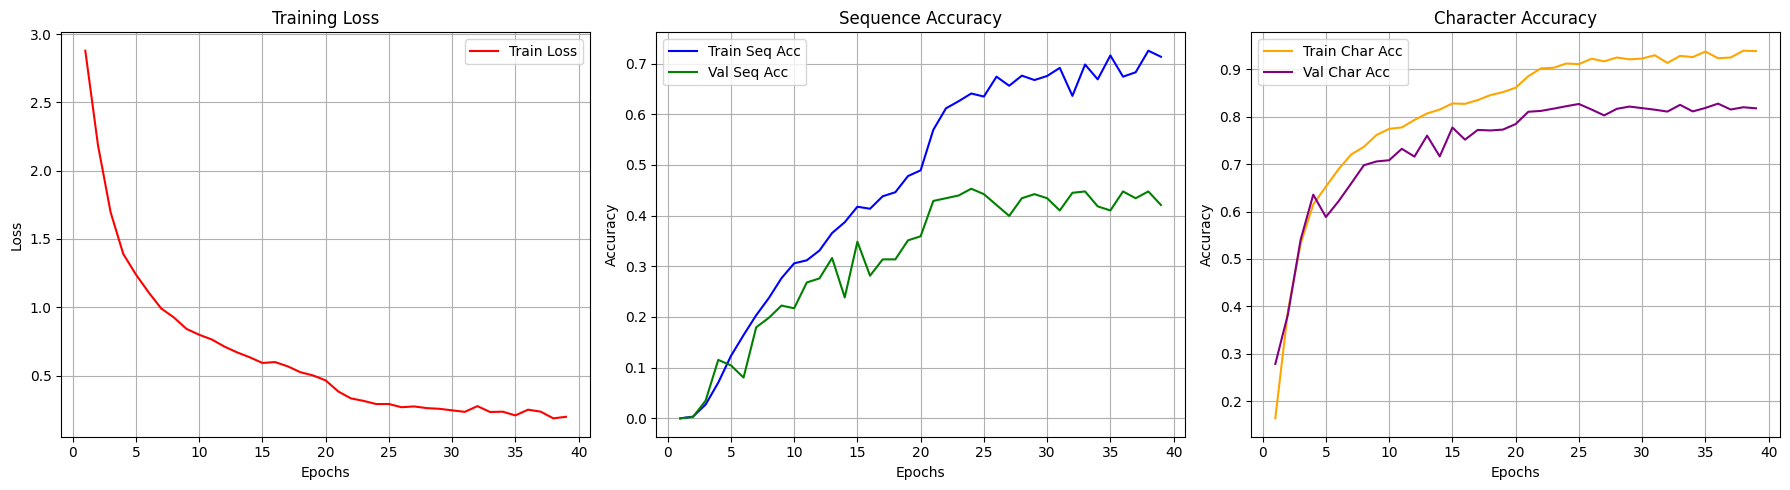

In [15]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    
    plt.figure(figsize=(18, 5))

    # 1. Loss Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", color='red')
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # 2. Sequence Accuracy Plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_seq_acc"], label="Train Seq Acc", color='blue')
    plt.plot(epochs, history["val_seq_acc"], label="Val Seq Acc", color='green')
    plt.title("Sequence Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # 3. Character Accuracy Plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["train_char_acc"], label="Train Char Acc", color='orange')
    plt.plot(epochs, history["val_char_acc"], label="Val Char Acc", color='purple')
    plt.title("Character Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Panggil fungsi
plot_training_history(history)